### Imports

In [77]:
import numpy as np
import datetime as dt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import statsmodels.api as sm
from scipy.signal import savgol_filter
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [78]:
def ConfIntervalMean(sample):
    confidence_level = 0.95
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)
    sample_size = len(sample)
    standard_error = sample_std / np.sqrt(sample_size)
    degrees_of_freedom = sample_size - 1

    # Calculate confidence interval
    conf_interval = stats.t.interval(confidence_level, df=degrees_of_freedom, loc=sample_mean, scale=standard_error)
    # print(f"95% Confidence Interval (t-distribution): {conf_interval}")

    return round(float(conf_interval[0]),6),round(float(conf_interval[1]),6)

def DescribeCI(sample):
    describeCI = sample.describe()
    CI_series = ConfIntervalMean(sample)
    CI_series = pd.Series([CI_series[0],CI_series[1]], index=["CI lower","CI upper"])

    result = pd.Series(np.concatenate((describeCI.values,CI_series.values)), index=describeCI.index.append(CI_series.index), name=describeCI.name)
    result = result[[
        "count",
        "mean",
        "std",
        "CI lower",
        "CI upper",
        "min","25%","50%","75%","max"
    ]]


    return result

def GetDataByLane(df,lane):
    df_analysis = df.copy()

    lane = str(lane)

    df_analysis["Lane"] = lane

    if len(lane)>0:
        lane = "Lane "+lane+" "

    # Imperial system to metric system
    for col in df_analysis.columns:
        if "Flow" in col:
            df_analysis[col.replace("5 Minutes","hour")] = df_analysis[col]*12
        if "Speed" in col:
            df_analysis[col.replace("mph","km/h")] = df_analysis[col]*1.60934

    # Main cols
    datetime = "5 Minutes"
    flow_col = f"{lane}Flow (Veh/hour)"
    speed_col = f"{lane}Speed (km/h)"
    density_col = f"{lane}Density (Veh/km)"

    # Sort data
    df_analysis = df_analysis.sort_values(datetime)

    # Calculate decimal hours
    df_analysis["Decimal Hours"] = df_analysis[datetime].dt.hour + df_analysis[datetime].dt.minute / 60 + df_analysis[datetime].dt.second / 3600
    df_analysis["Weekday"] = df_analysis[datetime].dt.day_name()
    df_analysis["Date"] = df_analysis[datetime].dt.strftime('%Y-%m-%d')
    df_analysis["Gradient Speed SG_3_1 (km/h2)"] =savgol_filter( np.gradient(df_analysis[speed_col],df_analysis["Decimal Hours"]), window_length=3, polyorder=1)

    # Density
    df_analysis[density_col] = df_analysis[flow_col]/df_analysis[speed_col]
    # LOS
    df_analysis["LOS"] = df_analysis[density_col].apply(lambda value:LOS(value,mode="MS"))

    df_analysis = df_analysis[["Lane",datetime,"Decimal Hours","Weekday","Date",flow_col,speed_col,density_col,"Gradient Speed SG_3_1 (km/h2)","LOS","% Observed"]]
    df_analysis = df_analysis.rename(columns={
        flow_col:"Flow (Veh/h)",
        speed_col:"Speed (km/h)",
        density_col:"Density (Veh/km)",
    })

    return df_analysis

def LOS(density,mode="MS"):
    mode_list = ["MS","IS"]

    if mode not in mode_list:
        raise ValueError(f"'{mode}' not in options '{mode_list}'")
    if mode=="MS":
        density = density*1.60934

    if density<=11:
        return "A"
    if density<=18:
        return "B"
    if density<=26:
        return "C"
    if density<=35:
        return "D"
    if density<=45:
        return "E"
    return "F"

def HCM6_Speed_Flow(FFS,flow,mode="MS"):
    mode_list = ["MS","IS"]

    if mode not in mode_list:
        raise ValueError(f"'{mode}' not in options '{mode_list}'")
    if mode=="MS":
        FFS = FFS/1.60934

    if not (50 <= FFS <= 80):
        raise ValueError("FFS should be between 50 and 80 mph for valid results.")

    SAF = 1
    FFS_adj = FFS*SAF

    c = min(2200+10*(FFS - 50),2400)
    CAF = 1
    c_adj = c*CAF

    Dc = 45

    BP = (1000+40*(75-FFS))*CAF
    a = 2.0

    if flow <= BP:
        speed = FFS_adj
    elif flow <= c:
        reduction = (FFS_adj-(c_adj/Dc))*((flow-BP)**a)/((c_adj-BP)**a)
        speed = FFS_adj - reduction
    else:
        speed = 0

    if mode=="MS":
        speed = speed*1.60934

    return speed

### Data

In [79]:
# root_path = ""
# os.chdir(root_path)
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'Data Analysis.ipynb',
 'example_dataset',
 'LICENSE',
 'README.md']

In [80]:
# Main path
folder_df = "example_dataset"
lane_list = [str(i) for i in [1,2,3,4]]

# Read raw data
df = []
for f in os.listdir(folder_df):
    df_ = pd.read_excel(os.path.join(folder_df,f),sheet_name="Report Data")
    df.append(df_)
df = pd.concat(df,ignore_index=True)

# Processed data
df_analysis = pd.concat([GetDataByLane(df,i) for i in lane_list])
df_analysis = df_analysis.sort_values(by=["Lane","5 Minutes"])

# Filter inc
drop_inc_date = [
    "2025-09-11",
    "2025-09-12",
    "2025-09-14",
    "2025-09-15",
    "2025-09-18",
    "2025-09-20",
    "2025-09-21",
    "2025-09-25",
    "2025-09-27",
    "2025-09-29",
]
df_analysis = df_analysis[(-df_analysis["Date"].isin(drop_inc_date))]

# Flow Class
df_analysis["Flow Class (Veh/h)"] = pd.cut(df_analysis["Flow (Veh/h)"],bins=np.arange(0,3000,100),right=False)

# Show data
df_analysis.head()

,Lane,5 Minutes,Decimal Hours,Weekday,Date,Flow (Veh/h),Speed (km/h),Density (Veh/km),Gradient Speed SG_3_1 (km/h2),LOS,% Observed,Flow Class (Veh/h)
0,1,2025-09-01 00:00:00,0.000000,Monday,2025-09-01,132,120.378632,1.096540,-1.609340e-01,A,100,"[100, 200)"
1,1,2025-09-01 00:05:00,0.083333,Monday,2025-09-01,72,120.378632,0.598113,3.218680e-01,A,100,"[0, 100)"
2,1,2025-09-01 00:10:00,0.166667,Monday,2025-09-01,180,120.378632,1.495282,3.218680e-01,A,100,"[100, 200)"
3,1,2025-09-01 00:15:00,0.250000,Monday,2025-09-01,36,120.539566,0.298657,7.579123e-14,A,100,"[0, 100)"
4,1,2025-09-01 00:20:00,0.333333,Monday,2025-09-01,120,120.378632,0.996855,-6.437360e-01,A,100,"[100, 200)"


### Time Series

In [81]:
def PlotTimeSeries(df,plot_var,lane="1",hue="Weekday",hue_order=['Sunday','Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']):
    fig, ax = plt.subplots(figsize=(12,6))

    sns.lineplot(
        data=df[df["Lane"]==lane],
        x="Decimal Hours",
        y=plot_var,
        hue=hue,
        hue_order=hue_order,
        estimator='mean',
        errorbar=('ci',95),
        ax=ax
        )

    ax.set_title(f"Time Series {plot_var}")
    ax.set_xlabel("Decimal Hours")
    ax.set_ylabel(f"{plot_var}")
    plt.legend()

    return ax

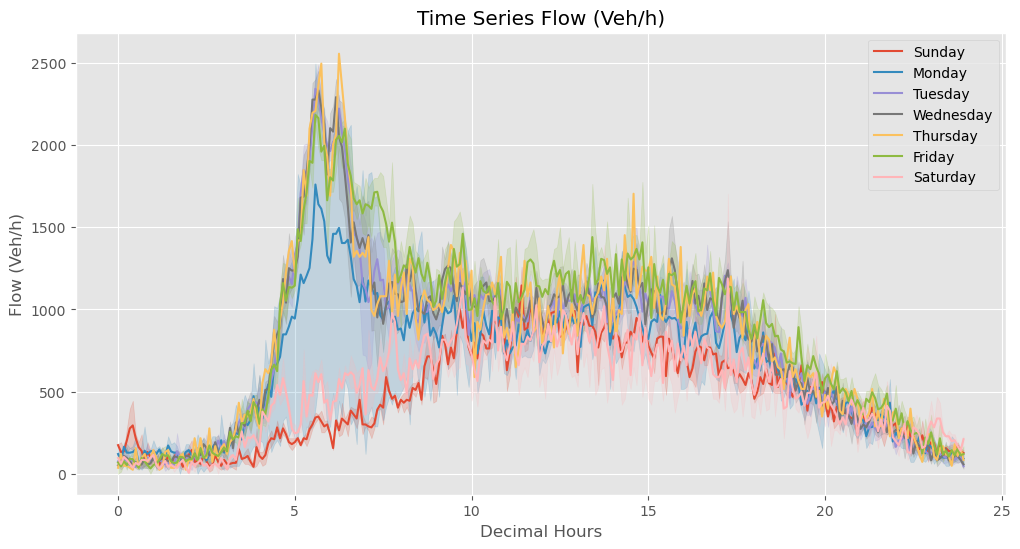

<Figure size 640x480 with 0 Axes>

In [82]:
PlotTimeSeries(df_analysis,"Flow (Veh/h)")
plt.show()
plt.clf()

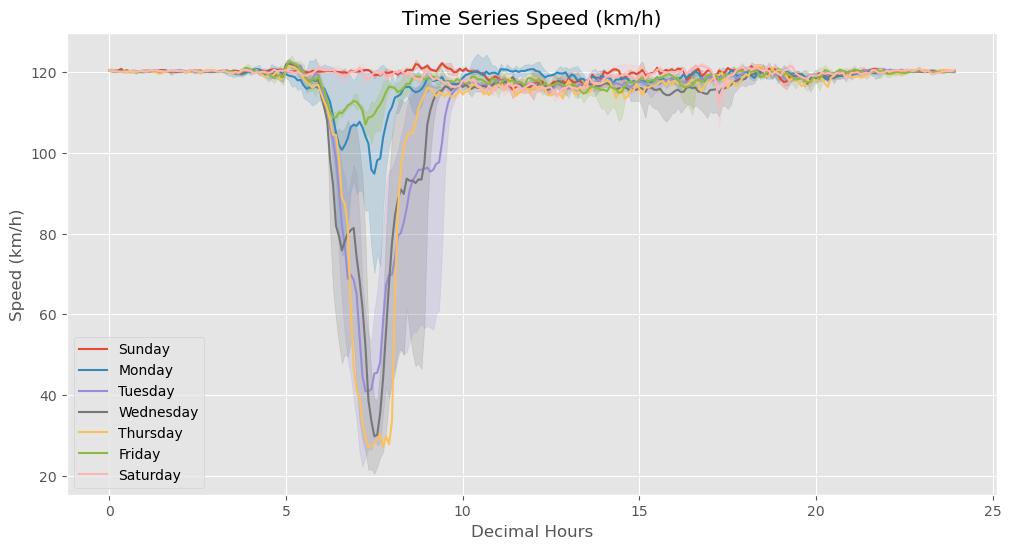

<Figure size 640x480 with 0 Axes>

In [83]:
PlotTimeSeries(df_analysis,"Speed (km/h)")
plt.show()
plt.clf()

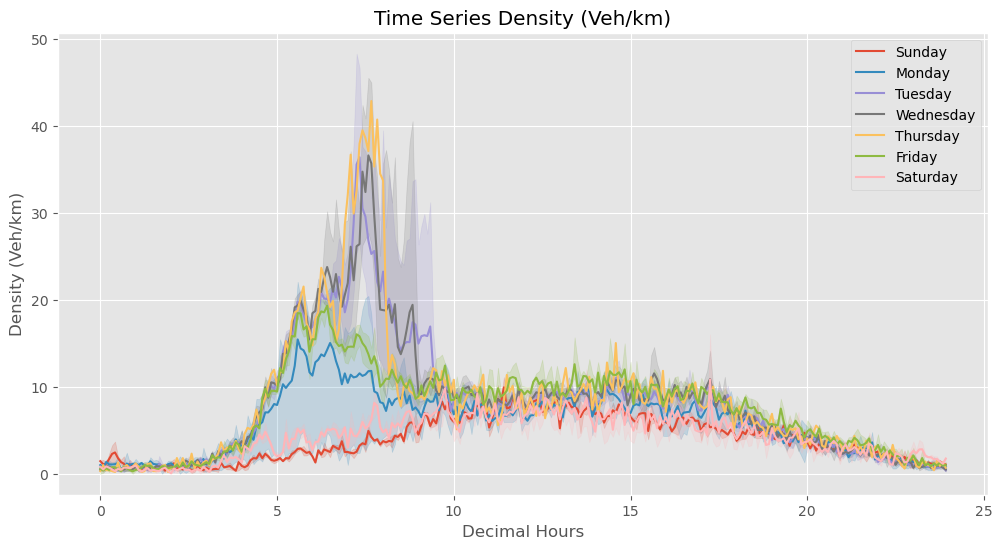

<Figure size 640x480 with 0 Axes>

In [84]:
PlotTimeSeries(df_analysis,"Density (Veh/km)")
plt.show()
plt.clf()

### Hist

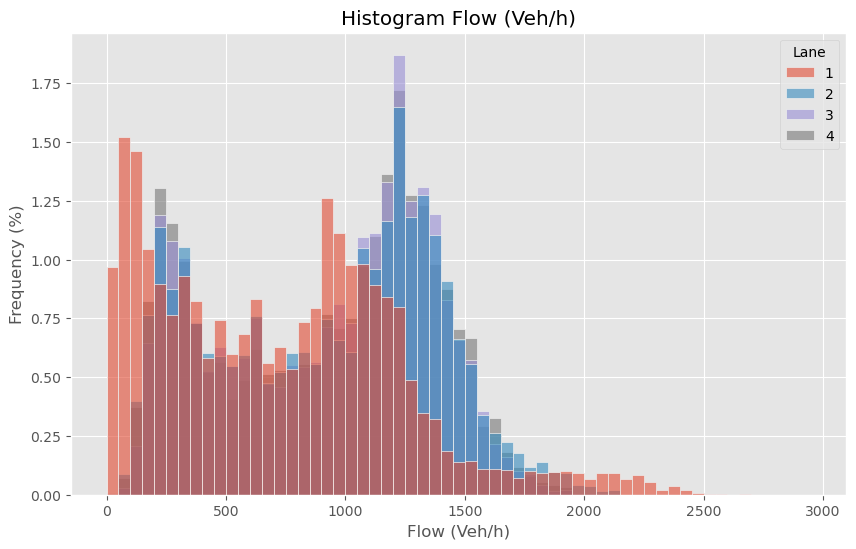

<Figure size 640x480 with 0 Axes>

In [85]:
plot_var = "Flow (Veh/h)"
plt.figure(figsize=(10, 6))
sns.histplot(data=df_analysis,x=plot_var,bins=np.arange(0,3000,50),alpha=0.6,stat="percent",hue="Lane") #,color="#8c3ac1"
plt.title(f"Histogram {plot_var}")
plt.xlabel(plot_var)
plt.ylabel("Frequency (%)")
plt.show()
plt.clf()

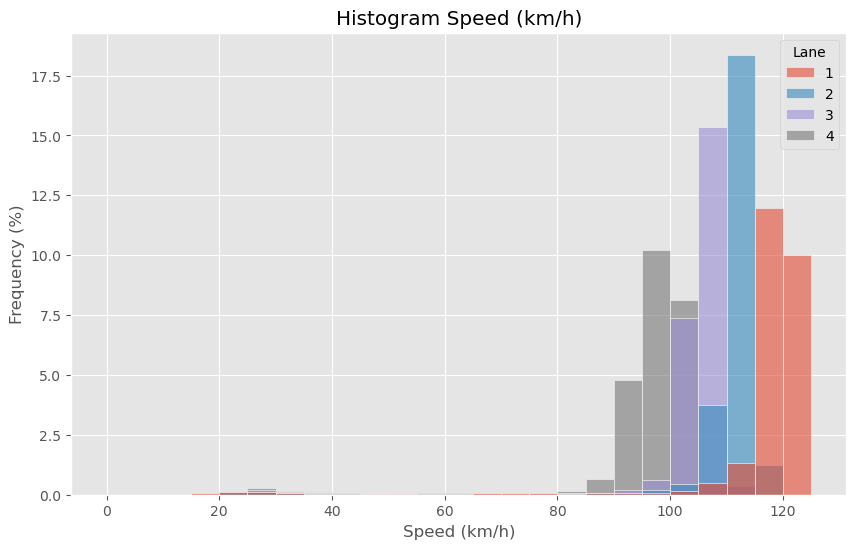

<Figure size 640x480 with 0 Axes>

In [86]:
plot_var = "Speed (km/h)"
plt.figure(figsize=(10, 6))
sns.histplot(data=df_analysis,x=plot_var,bins=np.arange(0,130,5),alpha=0.6,stat="percent",hue="Lane") #,color="#8c3ac1"
plt.title(f"Histogram {plot_var}")
plt.xlabel(plot_var)
plt.ylabel("Frequency (%)")
plt.show()
plt.clf()

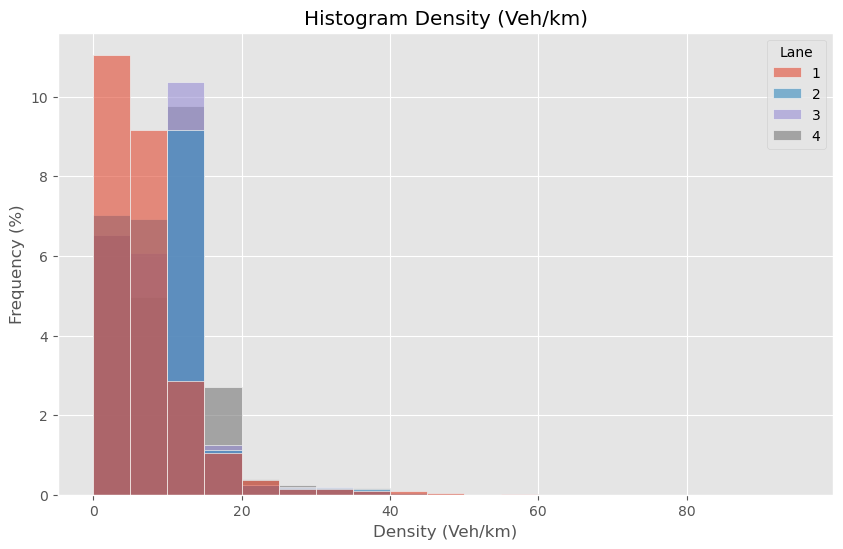

<Figure size 640x480 with 0 Axes>

In [87]:
plot_var = "Density (Veh/km)"
plt.figure(figsize=(10, 6))
sns.histplot(data=df_analysis,x=plot_var,bins=np.arange(0,100,5),alpha=0.6,stat="percent",hue="Lane") #,color="#8c3ac1"
plt.title(f"Histogram {plot_var}")
plt.xlabel(plot_var)
plt.ylabel("Frequency (%)")
plt.show()
plt.clf()

### Relationship between variables

In [88]:
def ScatterPlot(df,x_var,y_var,hue="Lane",hue_order=["1","2","3","4"]):
    fig, ax = plt.subplots(figsize=(12,6))
    sns.scatterplot(
        data=df,
        x=x_var,
        y=y_var,
        alpha=0.6,
        hue=hue,
        hue_order=hue_order,
        ax=ax
        )

    ax.set_title(f"{x_var} x {y_var} by {hue}")
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    plt.legend()

    return ax

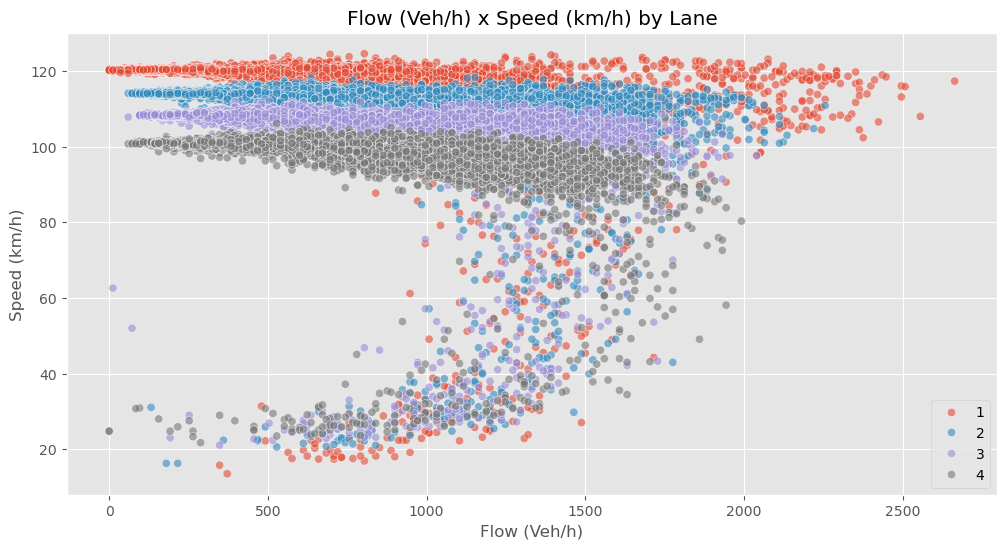

<Figure size 640x480 with 0 Axes>

In [89]:
ScatterPlot(df_analysis,"Flow (Veh/h)","Speed (km/h)")
plt.show()
plt.clf()

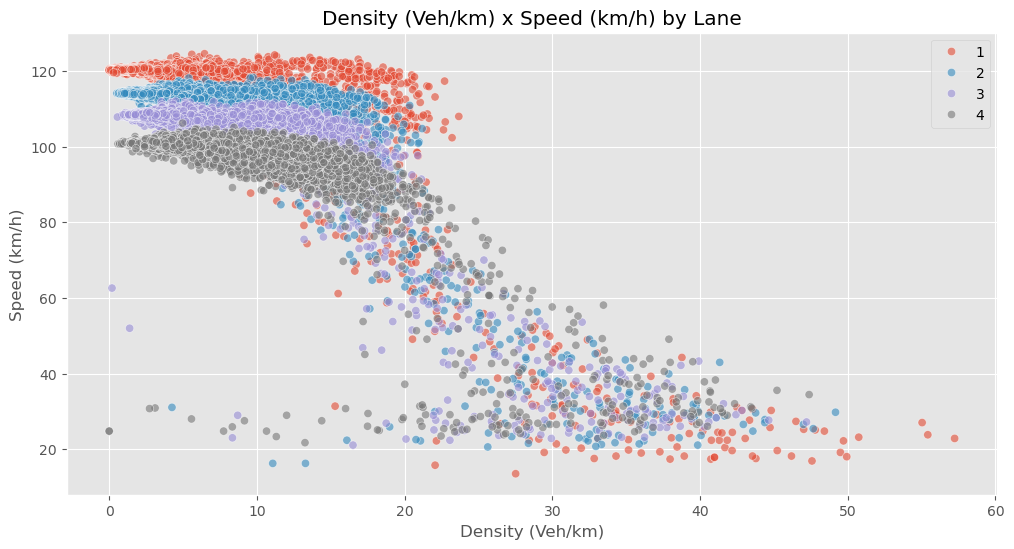

<Figure size 640x480 with 0 Axes>

In [90]:
ScatterPlot(df_analysis,"Density (Veh/km)","Speed (km/h)")
plt.show()
plt.clf()

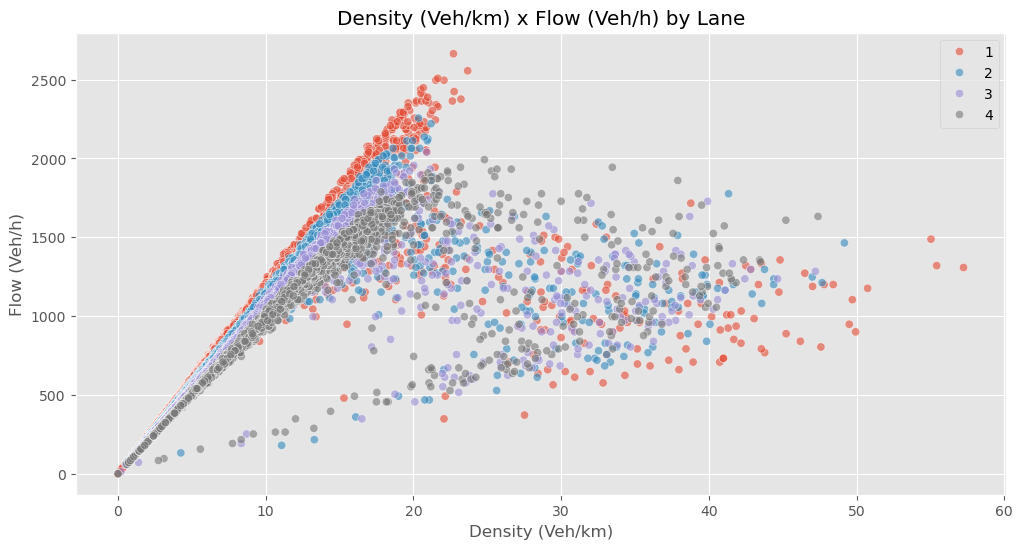

<Figure size 640x480 with 0 Axes>

In [91]:
ScatterPlot(df_analysis,"Density (Veh/km)","Flow (Veh/h)")
plt.show()
plt.clf()

### Capacity Model

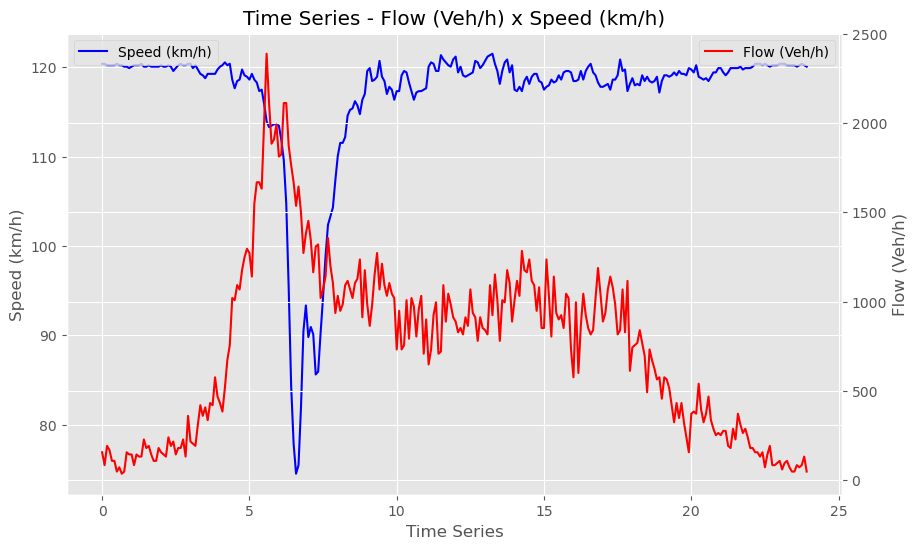

<Figure size 640x480 with 0 Axes>

In [92]:
# example
start_day = "2025-09-22 00:00:00"
end_day = "2025-09-22 23:59:59"
lane = "1"

df_ = df_analysis.copy()
df_ = df_[(df_["5 Minutes"].between(start_day,end_day)) & (df_["Lane"]==lane)]

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

sns.lineplot(
    data=df_,
    x="Decimal Hours",
    y="Flow (Veh/h)", # "Gradient Speed"
    c="r",
    label="Flow (Veh/h)",
    estimator='mean',
    errorbar=('ci',95),
    ax=ax2,
    dashes=True
    )

sns.lineplot(
    data=df_,
    x="Decimal Hours",
    y="Speed (km/h)",
    c="b",
    label="Speed (km/h)",
    estimator='mean',
    errorbar=('ci',95),
    ax=ax1,
    dashes=False
    )

ax1.set_xlabel('Time Series')
ax1.set_ylabel('Speed (km/h)')
ax2.set_ylabel('Flow (Veh/h)')
ax1.set_title("Time Series - Flow (Veh/h) x Speed (km/h)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
# ax1.grid()
# ax2.grid()

plt.show()
plt.clf()

In [93]:
def CapacityModel1(df):
    """
    Capacity with
    Breakdown flow (BDF): speed drop below 80 km/h with duration of at 3 obs.
    Estimator: Mean 3 obs before BDF
    """
    df_ = df.copy()
    w_forward = 3
    w_backward = 3

    df_capacity = []
    for date in df_["Date"].unique():
        df_date = df_[df_["Date"]==date].reset_index(drop=True)
        max_index = len(df_date) - 1

        for index,row in df_date.iterrows():
            if index > max_index - w_forward:
                df_date.loc[index,"Breakdown flow"] = np.nan
            else:
                if df_date.loc[index:index+w_forward-1]["Speed (km/h)"].min()<80:
                    df_date.loc[index,"Breakdown flow"] = True
                else:
                    df_date.loc[index,"Breakdown flow"] = False

            # Method
            df_date.loc[index,"Capacity (Veh/h)"] = df_date.loc[index-w_backward:index-1]["Flow (Veh/h)"].mean()

        BDF = df_date[df_date["Breakdown flow"]==True]
        if not BDF.empty:
            df_capacity.append(BDF.iloc[:1])

    if len(df_capacity)>0:
        df_capacity = pd.concat(df_capacity,ignore_index=True)

    return df_capacity

def CapacityModel2(df):
    """
    Capacity with
    Breakdown flow (BDF): density increase over 28 Veh/km with duration of at 3 obs.
    Estimator: Mean 3 obs before BDF
    """
    df_ = df.copy()
    w_forward = 3
    w_backward = 3

    df_capacity = []
    for date in df_["Date"].unique():
        df_date = df_[df_["Date"]==date].reset_index(drop=True)
        max_index = len(df_date) - 1

        for index,row in df_date.iterrows():
            if index > max_index - w_forward:
                df_date.loc[index,"Breakdown flow"] = np.nan
            else:
                cond1 = df_date.loc[index:index+w_forward-1]["Density (Veh/km)"].min()>28
                cond2 = df_date.loc[index:index+w_forward-1]["Gradient Speed SG_3_1 (km/h2)"].min()<-100
                if cond1 or cond2:
                    df_date.loc[index,"Breakdown flow"] = True
                else:
                    df_date.loc[index,"Breakdown flow"] = False

            # Method
            df_date.loc[index,"Capacity (Veh/h)"] = df_date.loc[index-w_backward:index-1]["Flow (Veh/h)"].mean()

        BDF = df_date[df_date["Breakdown flow"]==True]
        if not BDF.empty:
            df_capacity.append(BDF.iloc[:1])

    if len(df_capacity)>0:
        df_capacity = pd.concat(df_capacity,ignore_index=True)

    return df_capacity

In [94]:
# Run models
df_capacity_model1 = pd.concat([CapacityModel1(df_analysis[df_analysis["Lane"]==str(i)]) for i in lane_list])
df_capacity_model1 = df_capacity_model1.sort_values(by=["Lane","5 Minutes"])

df_capacity_model2 = pd.concat([CapacityModel2(df_analysis[df_analysis["Lane"]==str(i)]) for i in lane_list])
df_capacity_model2 = df_capacity_model2.sort_values(by=["Lane","5 Minutes"])

In [95]:
# df_capacity_model1.to_excel("CapModel1.xlsx",index=False)
# df_capacity_model2.to_excel("CapModel2.xlsx",index=False)

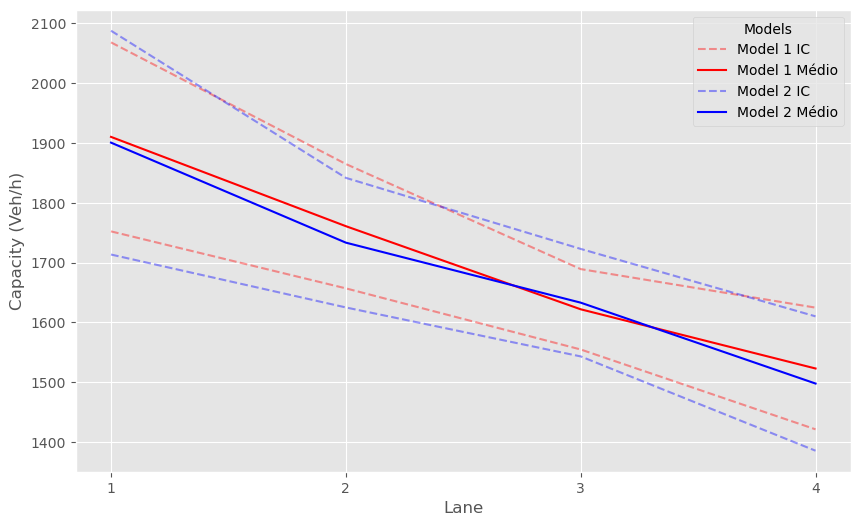

,Model,Lane,count,mean,std,CI lower,CI upper,min,25%,50%,75%,max
0,Model 1,1,12.0,1910.3,248.7,1752.3,2068.4,1452.0,1716.0,2018.0,2047.0,2284.0
1,Model 2,1,11.0,1900.7,278.6,1713.6,2087.9,1424.0,1694.0,1972.0,2122.0,2244.0
2,Model 1,2,12.0,1761.0,163.7,1657.0,1865.0,1536.0,1672.0,1710.0,1875.0,2120.0
3,Model 2,2,11.0,1733.5,161.3,1625.1,1841.8,1504.0,1628.0,1680.0,1842.0,2012.0
4,Model 1,3,12.0,1622.0,105.8,1554.8,1689.2,1436.0,1575.0,1640.0,1674.0,1788.0
5,Model 2,3,11.0,1633.1,133.8,1543.2,1723.0,1484.0,1536.0,1628.0,1678.0,1952.0
6,Model 1,4,12.0,1523.0,160.2,1421.2,1624.8,1328.0,1374.0,1522.0,1672.0,1764.0
7,Model 2,4,11.0,1497.8,167.2,1385.5,1610.2,1288.0,1378.0,1436.0,1630.0,1764.0


<Figure size 640x480 with 0 Axes>

In [96]:
# Compare models
models_dict = {
    "Model 1":df_capacity_model1,
    "Model 2":df_capacity_model2
}
df_summarize = []

for lane in lane_list:
    for model_name, model in models_dict.items():
        df_sum = pd.DataFrame(DescribeCI(model[model["Lane"]==str(lane)]["Capacity (Veh/h)"])).T.reset_index()
        df_sum["index"] = lane
        df_sum.insert(0,"Model",model_name)
        df_summarize.append(df_sum)

df_summarize = pd.concat(df_summarize,ignore_index=True)
df_summarize = df_summarize.rename(columns={"index":"Lane"})

fig, ax = plt.subplots(figsize=(10, 6))

color_models = {
    "Model 1":"red",
    "Model 3":"green",
    "Model 2":"blue",
}
for model_name, model in models_dict.items():
        sns.lineplot(
            data=df_summarize[df_summarize["Model"]==model_name],
            x="Lane",y='CI upper',
            label=model_name+" IC",
            color=color_models[model_name],
            linestyle="--",
            alpha=0.4,
            ax=ax)
        sns.lineplot(
            data=df_summarize[df_summarize["Model"]==model_name],
            x="Lane",y='mean',
            label=model_name+" Médio",
            color=color_models[model_name],
            linestyle="-",
            ax=ax)
        sns.lineplot(
            data=df_summarize[df_summarize["Model"]==model_name],
            x="Lane",y='CI lower',
            # label=model_name+" CI lower",
            color=color_models[model_name],
            linestyle="--",
            alpha=0.4,
            ax=ax,
            legend=False)

ax.set_xlabel("Lane")
ax.set_ylabel("Capacity (Veh/h)")
plt.legend(title="Models")
plt.show()
plt.clf()

df_summarize.round(1)

In [97]:
# df_summarize.to_excel("ResumoCapacidade.xlsx",index=False)

### LOS Typical Day

In [98]:
df_LOS_TD = df_analysis.copy()
df_LOS_TD = df_LOS_TD.sort_values(by=["Lane","5 Minutes"])
df_LOS_TD["Density SMA_3 (Veh/km)"] = df_LOS_TD["Density (Veh/km)"].rolling(window=3).mean().fillna(0)
df_LOS_TD = df_LOS_TD[-df_LOS_TD["Weekday"].isin(["Friday","Saturday","Sunday"])]

In [99]:
df_summarize = []
for lane in sorted(df_LOS_TD["Lane"].unique()):
    for dh in sorted(df_LOS_TD["Decimal Hours"].unique()):

        df_lane_dh = df_LOS_TD[(df_LOS_TD["Lane"]==lane) & (df_LOS_TD["Decimal Hours"]==dh)]

        df_sum = pd.DataFrame(DescribeCI(df_lane_dh["Density SMA_3 (Veh/km)"])).T.reset_index()
        df_sum.insert(0,"Decimal Hours",dh)
        df_sum.insert(0,"Lane",lane)

        df_summarize.append(df_sum)

df_summarize = pd.concat(df_summarize,ignore_index=True).fillna(0).rename(columns={"count":"N","index":"Parameter"})

df_summarize["LOS CI lower"] = df_summarize["CI upper"].apply(lambda value:LOS(value,mode="MS"))
df_summarize["LOS mean"] = df_summarize["mean"].apply(lambda value:LOS(value,mode="MS"))
df_summarize["LOS CI upper"] = df_summarize["CI lower"].apply(lambda value:LOS(value,mode="MS"))

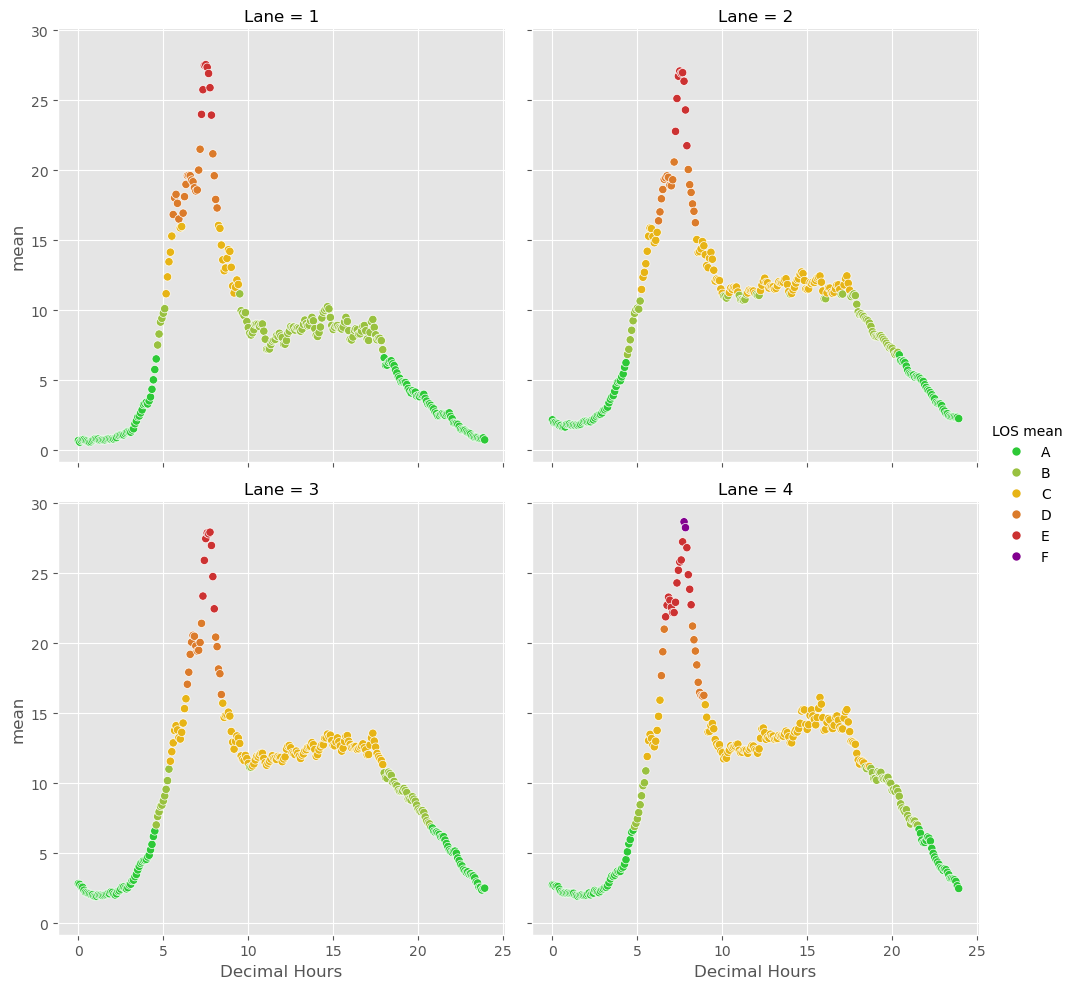

<Figure size 640x480 with 0 Axes>

In [100]:
sns.relplot(
    data=df_summarize, kind="scatter",
    x="Decimal Hours",y="mean",
    col="Lane",col_wrap=2,
    hue="LOS mean",hue_order=["A","B","C","D","E","F"],
    palette=dict(zip(["A","B","C","D","E","F"], ["#2dc937","#99c140","#e7b416","#db7b2b","#cc3232","#82008f"])),
)

plt.show()
plt.clf()

In [101]:
df_summarize.head()[['Lane','Decimal Hours',"N",'CI lower','mean','CI upper','LOS CI lower','LOS mean','LOS CI upper']]

,Lane,Decimal Hours,N,CI lower,mean,CI upper,LOS CI lower,LOS mean,LOS CI upper
0,1,0.000000,13.0,0.520072,0.690555,0.861038,A,A,A
1,1,0.083333,13.0,0.427163,0.582781,0.738399,A,A,A
2,1,0.166667,13.0,0.542668,0.703044,0.863421,A,A,A
3,1,0.250000,13.0,0.609786,0.759757,0.909729,A,A,A
4,1,0.333333,13.0,0.578249,0.765109,0.951968,A,A,A


In [102]:
# df_summarize.to_excel("LOS.xlsx",index=False)

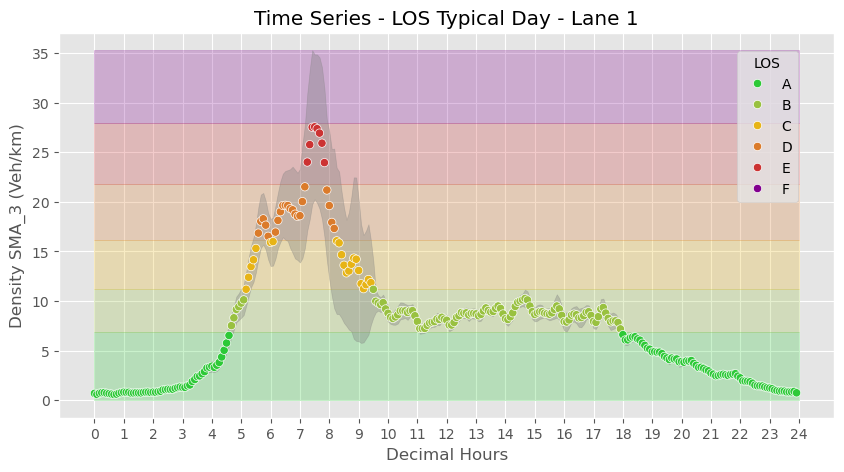

<Figure size 640x480 with 0 Axes>

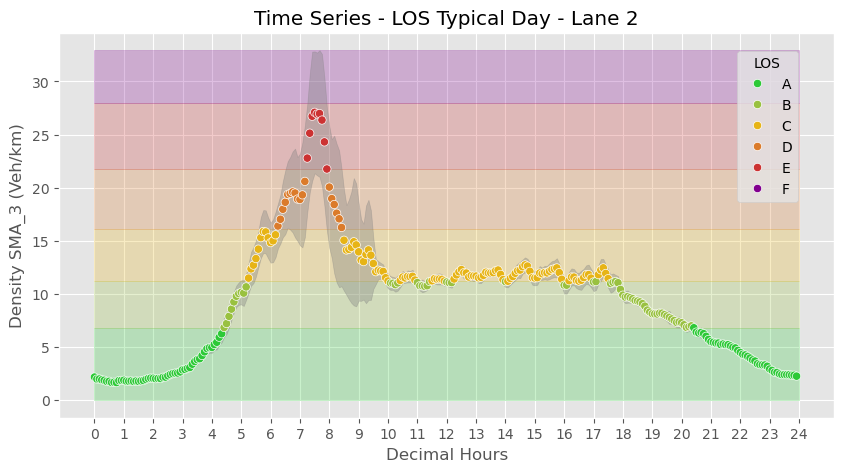

<Figure size 640x480 with 0 Axes>

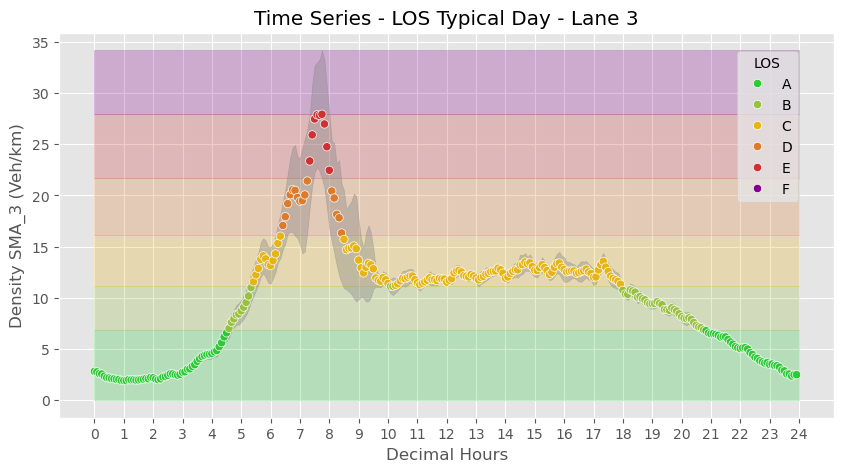

<Figure size 640x480 with 0 Axes>

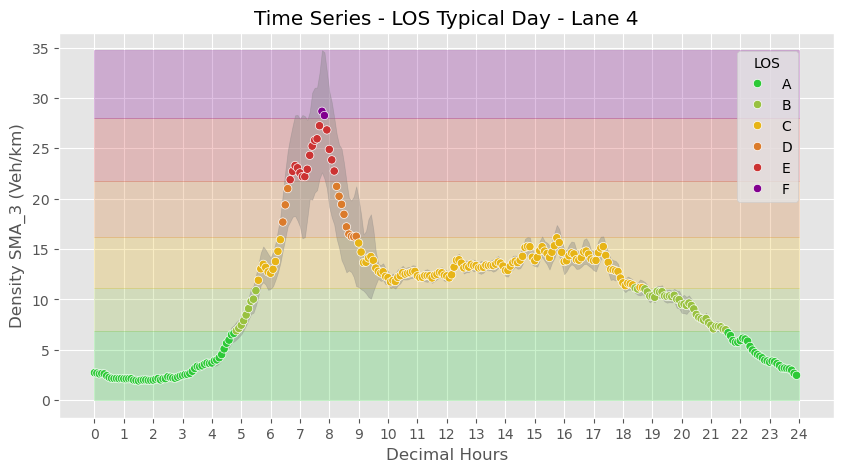

<Figure size 640x480 with 0 Axes>

In [105]:
for l in range(1,5):
    l = str(l)

    df_ = df_summarize[df_summarize["Lane"]==l]

    fig, ax = plt.subplots(figsize=(10,5))

    # A
    plt.fill_between([0,24],[i/1.60934 for i in [0,0]],[i/1.60934 for i in [11,11]], color='#2dc937',alpha=0.25)
    # B
    plt.fill_between([0,24],[i/1.60934 for i in [11,11]],[i/1.60934 for i in [18,18]], color='#99c140',alpha=0.25)
    # C
    plt.fill_between([0,24],[i/1.60934 for i in [18,18]],[i/1.60934 for i in [26,26]], color='#e7b416',alpha=0.25)
    # D
    plt.fill_between([0,24],[i/1.60934 for i in [26,26]],[i/1.60934 for i in [35,35]], color='#db7b2b',alpha=0.25)
    # E
    plt.fill_between([0,24],[i/1.60934 for i in [35,35]],[i/1.60934 for i in [45,45]], color='#cc3232',alpha=0.25)
    # F
    plt.fill_between([0,24],[i/1.60934 for i in [45,45]],[i for i in [max(df_["CI upper"]),max(df_["CI upper"])]], color='#82008f',alpha=0.25)

    plt.fill_between(df_["Decimal Hours"], df_["CI lower"], df_["CI upper"], color='grey',alpha=0.35)

    sns.scatterplot(
        data=df_,
        x="Decimal Hours",
        y="mean",
        hue="LOS mean",
        hue_order=["A","B","C","D","E","F"],
        palette=dict(zip(["A","B","C","D","E","F"], ["#2dc937","#99c140","#e7b416","#db7b2b","#cc3232","#82008f"])),
        ax=ax,
        legend=True
        )

    ax.set_title(f"Time Series - LOS Typical Day - Lane {l}")
    ax.set_xlabel("Decimal Hours")
    ax.set_ylabel("Density SMA_3 (Veh/km)")
    ax.set_xticks(np.arange(0,25,1))
    plt.legend(title="LOS",loc="upper right",bbox_to_anchor=(0.962,0.971))

    plt.show()
    plt.clf()

### Speed-Flow Curves for Basic Freeway Segments

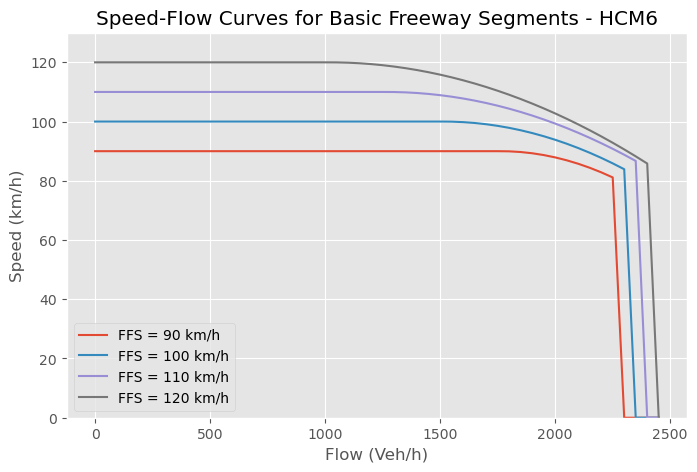

<Figure size 640x480 with 0 Axes>

In [54]:
# Test
fig, ax = plt.subplots(figsize=(8,5))

for i in range(90,125,10):
    x = np.arange(0,2500,50)
    y = np.vectorize(HCM6_Speed_Flow)(i,x)
    ax.plot(x,y,label=f"FFS = {i} km/h")

plt.ylim(0,130)
plt.title("Speed-FIow Curves for Basic Freeway Segments - HCM6")
plt.xlabel("Flow (Veh/h)")
plt.ylabel("Speed (km/h)")
plt.legend()

plt.show()
plt.clf()

In [71]:
def SpeedFlowCurve(df):
    """
    Capacity with
    Breakdown flow (BDF): density increase over 28 Veh/km with duration of at 3 obs.
    or
    Breakdown flow (BDF): speed drop below 80 km/h with duration of at 3 obs.
    """
    df_ = df.copy()
    df_uninterrupted_flow = []
    w_forward = 3
    w_backward = 3

    df_capacity = []
    for date in df_["Date"].unique():
        df_date = df_[df_["Date"]==date].reset_index(drop=True)
        max_index = len(df_date) - 1

        for index,row in df_date.iterrows():
            if index > max_index - w_forward:
                df_date.loc[index,"Breakdown flow"] = np.nan
            else:
                cond1 = df_date.loc[index:index+w_forward-1]["Density (Veh/km)"].min()>28
                cond2 = df_date.loc[index:index+w_forward-1]["Speed (km/h)"].min()<80
                if cond1 or cond2:
                    df_date.loc[index,"Breakdown flow"] = True
                else:
                    df_date.loc[index,"Breakdown flow"] = False

        BDF = df_date[df_date["Breakdown flow"]==True]
        if not BDF.empty:
            max_index = min(BDF.index.tolist()) - 1
            df_uninterrupted_flow.append(df_date.iloc[:max_index])

    if len(df_uninterrupted_flow)>0:
        df_uninterrupted_flow = pd.concat(df_uninterrupted_flow,ignore_index=True)

    return df_uninterrupted_flow

In [72]:
df_uninterrupted_flow = []
df_summarize = []

for lane in lane_list:
    df_uninterrupted_flow_ = SpeedFlowCurve(df_analysis[df_analysis["Lane"]==str(lane)])
    df_uninterrupted_flow_ = df_uninterrupted_flow_[df_uninterrupted_flow_["Speed (km/h)"]>=80]
    df_uninterrupted_flow_ = df_uninterrupted_flow_[df_uninterrupted_flow_["LOS"]!="F"]
    df_uninterrupted_flow.append(df_uninterrupted_flow_)
    for f in df_uninterrupted_flow_["Flow Class (Veh/h)"].unique().sort_values():
        df_sum = pd.DataFrame(DescribeCI(df_uninterrupted_flow_[df_uninterrupted_flow_["Flow Class (Veh/h)"]==f]["Speed (km/h)"])).T.reset_index()
        df_sum["index"] = lane
        df_sum.insert(0,"Flow Mid Class (Veh/h)",f.mid)
        df_sum.insert(0,"Flow Class (Veh/h)",f)
        df_summarize.append(df_sum)

df_summarize = pd.concat(df_summarize,ignore_index=True)
df_summarize = df_summarize.rename(columns={"index":"Lane"})
df_summarize = df_summarize.sort_values(by=["Lane","Flow Mid Class (Veh/h)"])
df_summarize["FFS"] = df_summarize["Lane"].apply(lambda value:{"1":120,"2":112,"3":104,"4":100}[value])

df_uninterrupted_flow = pd.concat(df_uninterrupted_flow,ignore_index=True)

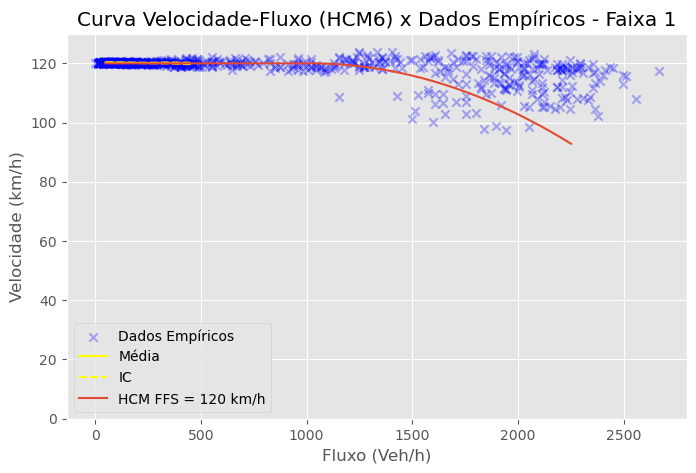

<Figure size 640x480 with 0 Axes>

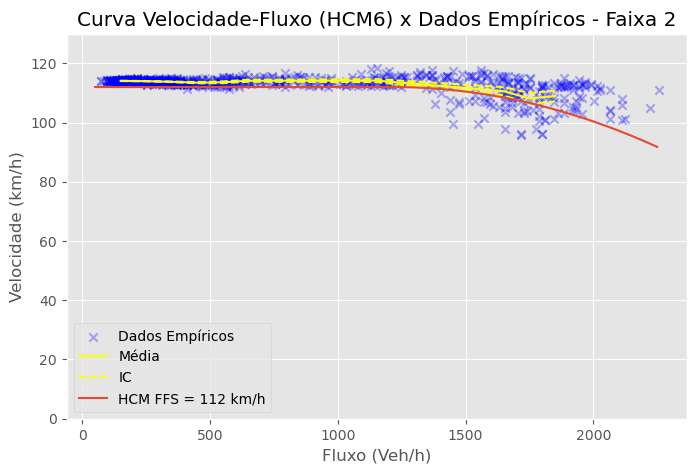

<Figure size 640x480 with 0 Axes>

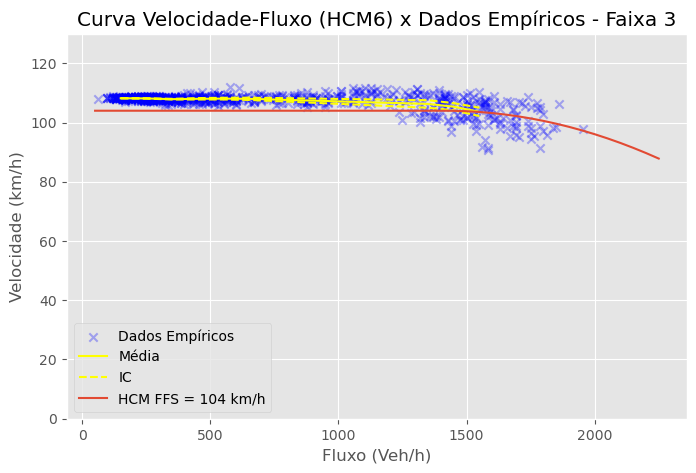

<Figure size 640x480 with 0 Axes>

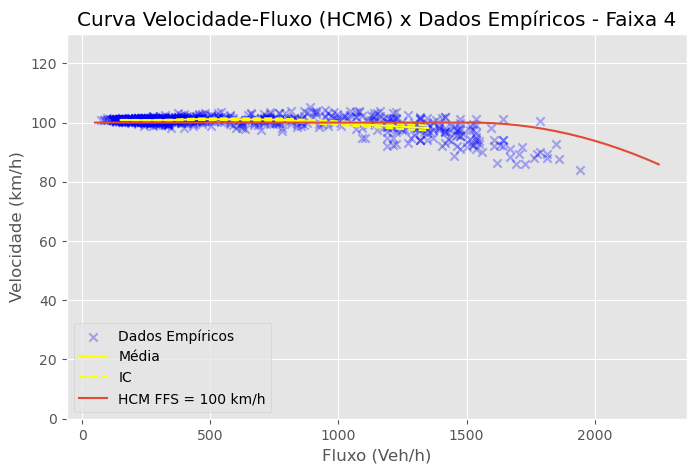

<Figure size 640x480 with 0 Axes>

In [73]:
# Test
df_comp = []
for l in range(1,5):
    l = str(l)
    fig, ax = plt.subplots(figsize=(8,5))

    df_ = df_uninterrupted_flow[df_uninterrupted_flow["Lane"]==l]
    ax.scatter(df_["Flow (Veh/h)"],df_["Speed (km/h)"],c="blue",alpha=0.3,label="Dados Empíricos",marker="x")

    df_ = df_summarize[(df_summarize["Lane"]==l) & (df_summarize["count"]>30)]
    ax.plot(df_["Flow Mid Class (Veh/h)"],df_["mean"],label="Média",c="yellow")
    ax.plot(df_["Flow Mid Class (Veh/h)"],df_["CI lower"],label="IC",c="yellow",linestyle ="--")
    ax.plot(df_["Flow Mid Class (Veh/h)"],df_["CI upper"],c="yellow",linestyle ="--")

    FFS = df_["FFS"].max()
    x = np.arange(50,2300,50)
    y = np.vectorize(HCM6_Speed_Flow)(FFS,x)
    ax.plot(x,y,label=f"HCM FFS = {FFS} km/h")
    df_HCM = pd.DataFrame()
    df_HCM["Flow Mid Class (Veh/h)"] = x
    df_HCM["Flow Mid Class (Veh/h)"] = df_HCM["Flow Mid Class (Veh/h)"].astype(float)
    df_HCM["Speed HCM6 (km/h)"] = y

    df_comp.append(df_.merge(df_HCM,on="Flow Mid Class (Veh/h)",how="left"))

    plt.ylim(00,130)
    plt.title(f"Curva Velocidade-Fluxo (HCM6) x Dados Empíricos - Faixa {l}")
    plt.xlabel("Fluxo (Veh/h)")
    plt.ylabel("Velocidade (km/h)")
    plt.legend()

    plt.show()
    plt.clf()

df_comp = pd.concat(df_comp,ignore_index=True)
df_comp["HCM6 between CI"] = df_comp.apply(lambda row: True if (row["Speed HCM6 (km/h)"]>=row["CI lower"]) and (row["Speed HCM6 (km/h)"]<=row["CI upper"]) else False,axis=1)

In [74]:
from sklearn.metrics import mean_squared_error

In [75]:
for l in range(1,5):
    l = str(l)
    df_comp_ = df_comp[df_comp["Lane"]==l]
    rmse2 = np.sqrt(mean_squared_error(df_comp_["mean"], df_comp_["Speed HCM6 (km/h)"]))
    print(f"RMSE Lane {l}:", round(rmse2, 3))

RMSE Lane 1: 0.161
RMSE Lane 2: 2.302
RMSE Lane 3: 3.439
RMSE Lane 4: 1.146


In [ ]:
# df_comp.to_excel("Obs Data x HCM6.xlsx",index=False)

In [ ]:
# df_uninterrupted_flow.to_excel("Obs Data Disaggregated.xlsx",index=False)

### LOS Typical Day with HCM

In [ ]:
df_LOS_TD

,Lane,5 Minutes,Decimal Hours,Weekday,Date,Flow (Veh/h),Speed (km/h),Density (Veh/km),Gradient Speed SG_3_1 (km/h2),LOS,% Observed,Flow Class (Veh/h),Density SMA_3 (Veh/km),FFS
15840,1,2025-06-02 00:00:00,0.000000,Monday,2025-06-02,24,120.378632,0.199371,1.568519e-05,A,100,"[0, 100)",0.133003,120
15841,1,2025-06-02 00:05:00,0.083333,Monday,2025-06-02,0,120.378632,0.000000,7.842596e-06,A,50,"[0, 100)",0.066457,120
15842,1,2025-06-02 00:10:00,0.166667,Monday,2025-06-02,0,120.378632,0.000000,3.789561e-14,A,75,"[0, 100)",0.066457,120
15843,1,2025-06-02 00:15:00,0.250000,Monday,2025-06-02,0,120.378632,0.000000,3.789561e-14,A,100,"[0, 100)",0.000000,120
15844,1,2025-06-02 00:20:00,0.333333,Monday,2025-06-02,0,120.378632,0.000000,3.789561e-14,A,100,"[0, 100)",0.000000,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15259,4,2025-07-30 23:35:00,23.583333,Wednesday,2025-07-30,48,101.227486,0.474180,3.862416e+00,A,100,"[0, 100)",1.112112,100
15260,4,2025-07-30 23:40:00,23.666667,Wednesday,2025-07-30,168,101.710288,1.651750,1.931208e+00,A,100,"[100, 200)",1.105053,100
15261,4,2025-07-30 23:45:00,23.750000,Wednesday,2025-07-30,144,101.549354,1.418030,3.218680e-01,A,100,"[100, 200)",1.181320,100
15262,4,2025-07-30 23:50:00,23.833333,Wednesday,2025-07-30,144,101.549354,1.418030,-3.218915e-01,A,100,"[100, 200)",1.495937,100


In [ ]:
df_LOS_TD = df_analysis.copy()
df_LOS_TD = df_LOS_TD.sort_values(by=["Lane","5 Minutes"])
df_LOS_TD["Density SMA_3 (Veh/km)"] = df_LOS_TD["Density (Veh/km)"].rolling(window=3).mean().fillna(0)
df_LOS_TD = df_LOS_TD[-df_LOS_TD["Weekday"].isin(["Friday","Saturday","Sunday"])]

# HCM values
# Speed
df_LOS_TD["FFS"] = 88
df_LOS_TD["Speed HCM (km/h)"] = df_LOS_TD.apply(lambda row:HCM6_Speed_Flow(row["FFS"],row["Flow (Veh/h)"]),axis=1)
# Density
df_LOS_TD["Density HCM (Veh/km)"] = df_LOS_TD["Flow (Veh/h)"]/df_LOS_TD["Speed HCM (km/h)"]
# Density SMA_3
df_LOS_TD["Density SMA_3 HCM (Veh/km)"] = df_LOS_TD["Density HCM (Veh/km)"].rolling(window=3).mean().fillna(0)
# LOS
df_LOS_TD["LOS HCM"] = df_LOS_TD["Density HCM (Veh/km)"].apply(lambda value:LOS(value,mode="MS"))

In [ ]:
df_summarize_before = []
df_summarize_after = []

for lane in sorted(df_LOS_TD["Lane"].unique()):
    for dh in sorted(df_LOS_TD["Decimal Hours"].unique()):

        df_lane_dh = df_LOS_TD[(df_LOS_TD["Lane"]==lane) & (df_LOS_TD["Decimal Hours"]==dh)]

        df_sum = pd.DataFrame(DescribeCI(df_lane_dh["Density SMA_3 (Veh/km)"])).T.reset_index()
        df_sum.insert(0,"Decimal Hours",dh)
        df_sum.insert(0,"Lane",lane)
        df_summarize_before.append(df_sum)

        df_sum = pd.DataFrame(DescribeCI(df_lane_dh["Density SMA_3 HCM (Veh/km)"])).T.reset_index()
        df_sum.insert(0,"Decimal Hours",dh)
        df_sum.insert(0,"Lane",lane)
        df_summarize_after.append(df_sum)

df_summarize_before = pd.concat(df_summarize_before,ignore_index=True).fillna(0).rename(columns={"count":"N","index":"Parameter"})
df_summarize_before["LOS CI lower"] = df_summarize_before["CI upper"].apply(lambda value:LOS(value,mode="MS"))
df_summarize_before["LOS mean"] = df_summarize_before["mean"].apply(lambda value:LOS(value,mode="MS"))
df_summarize_before["LOS CI upper"] = df_summarize_before["CI lower"].apply(lambda value:LOS(value,mode="MS"))

df_summarize_after = pd.concat(df_summarize_after,ignore_index=True).fillna(0).rename(columns={"count":"N","index":"Parameter"})
df_summarize_after["LOS CI lower"] = df_summarize_after["CI upper"].apply(lambda value:LOS(value,mode="MS"))
df_summarize_after["LOS mean"] = df_summarize_after["mean"].apply(lambda value:LOS(value,mode="MS"))
df_summarize_after["LOS CI upper"] = df_summarize_after["CI lower"].apply(lambda value:LOS(value,mode="MS"))

/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound

In [ ]:
df_summarize_before.head()# [['Lane','Decimal Hours',"N",'CI lower','mean','CI upper','LOS CI lower','LOS mean','LOS CI upper']]

,Lane,Decimal Hours,Parameter,N,mean,std,CI lower,CI upper,min,25%,50%,75%,max,LOS CI lower,LOS mean,LOS CI upper
0,1,0.000000,Density SMA_3 (Veh/km),30.0,0.349702,0.360527,0.215079,0.484325,0.0,0.132936,0.298790,0.481370,1.949685,A,A,A
1,1,0.083333,Density SMA_3 (Veh/km),30.0,0.271684,0.251386,0.177815,0.365553,0.0,0.099387,0.199482,0.406971,1.005197,A,A,A
2,1,0.166667,Density SMA_3 (Veh/km),30.0,0.192751,0.201949,0.117342,0.268160,0.0,0.066457,0.132914,0.224348,0.864252,A,A,A
3,1,0.250000,Density SMA_3 (Veh/km),30.0,0.156242,0.186562,0.086578,0.225905,0.0,0.000000,0.132738,0.191757,0.732362,A,A,A
4,1,0.333333,Density SMA_3 (Veh/km),30.0,0.130289,0.188763,0.059804,0.200774,0.0,0.000000,0.083005,0.166655,0.815496,A,A,A


In [ ]:
# df_summarize_before.to_excel("LOS_before.xlsx",index=False)
# df_summarize_after.to_excel("LOS_after.xlsx",index=False)

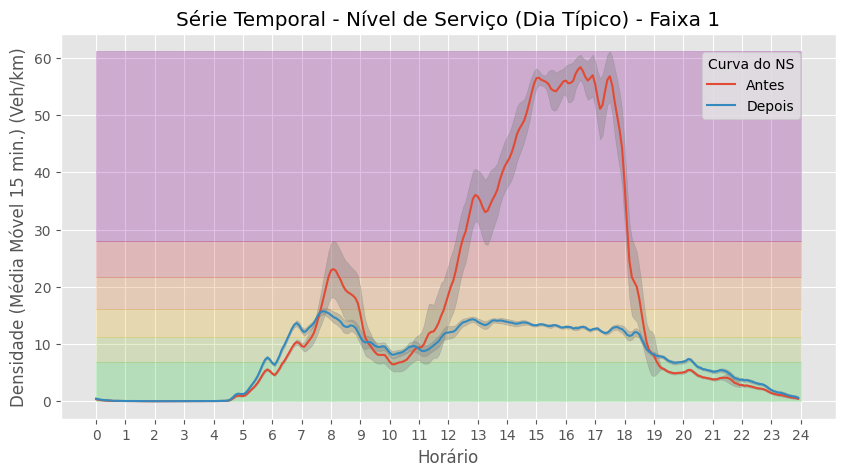

<Figure size 640x480 with 0 Axes>

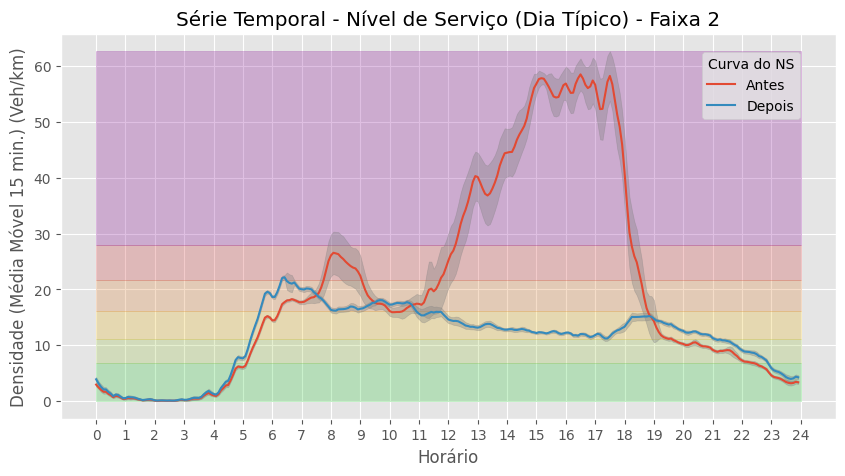

<Figure size 640x480 with 0 Axes>

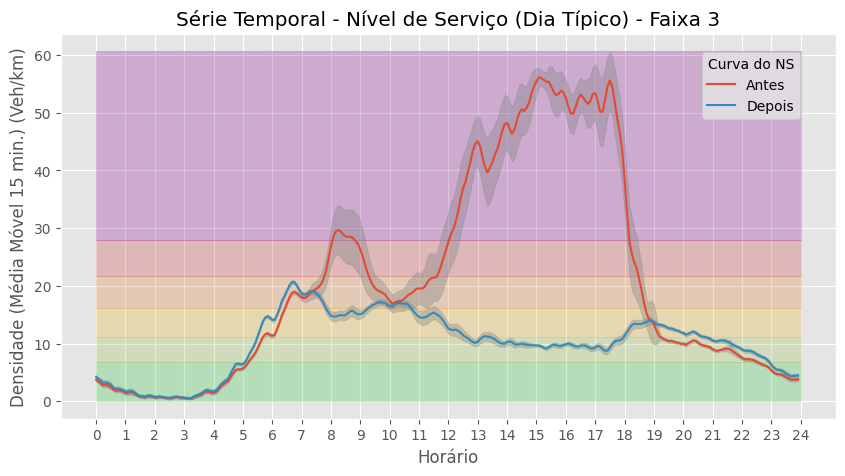

<Figure size 640x480 with 0 Axes>

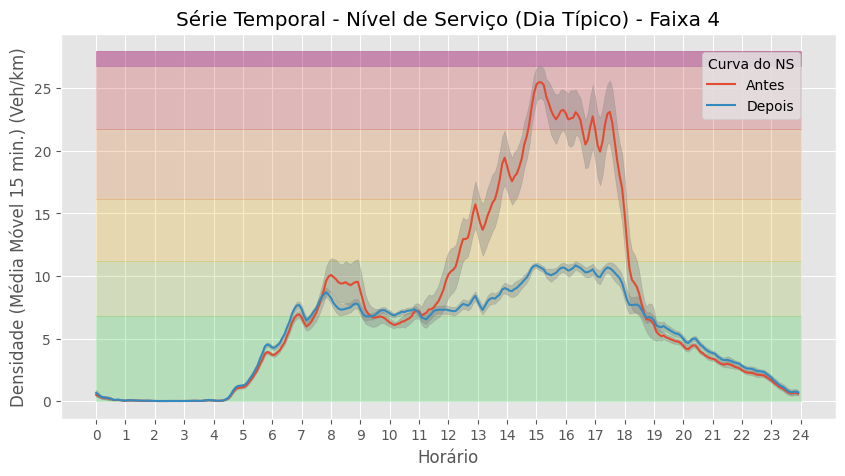

<Figure size 640x480 with 0 Axes>

In [ ]:
for l in range(1,5):
    l = str(l)

    df_ = df_summarize_before[df_summarize_before["Lane"]==l]

    fig, ax = plt.subplots(figsize=(10,5))

    # A
    plt.fill_between([0,24],[i/1.60934 for i in [0,0]],[i/1.60934 for i in [11,11]], color='#2dc937',alpha=0.25)
    # B
    plt.fill_between([0,24],[i/1.60934 for i in [11,11]],[i/1.60934 for i in [18,18]], color='#99c140',alpha=0.25)
    # C
    plt.fill_between([0,24],[i/1.60934 for i in [18,18]],[i/1.60934 for i in [26,26]], color='#e7b416',alpha=0.25)
    # D
    plt.fill_between([0,24],[i/1.60934 for i in [26,26]],[i/1.60934 for i in [35,35]], color='#db7b2b',alpha=0.25)
    # E
    plt.fill_between([0,24],[i/1.60934 for i in [35,35]],[i/1.60934 for i in [45,45]], color='#cc3232',alpha=0.25)
    # F
    plt.fill_between([0,24],[i/1.60934 for i in [45,45]],[i for i in [max(df_["CI upper"]),max(df_["CI upper"])]], color='#82008f',alpha=0.25)

    plt.fill_between(df_["Decimal Hours"], df_["CI lower"], df_["CI upper"], color='grey',alpha=0.35)
    sns.lineplot(
        data=df_,
        x="Decimal Hours",
        y="mean",
        # hue="LOS mean",
        # hue_order=["A","B","C","D","E","F"],
        # palette=dict(zip(["A","B","C","D","E","F"], ["#2dc937","#99c140","#e7b416","#db7b2b","#cc3232","#82008f"])),
        label="Antes",
        ax=ax,
        legend=True
        )

    df_ = df_summarize_after[df_summarize_before["Lane"]==l]
    plt.fill_between(df_["Decimal Hours"], df_["CI lower"], df_["CI upper"], color='grey',alpha=0.35)
    sns.lineplot(
        data=df_,
        x="Decimal Hours",
        y="mean",
        label="Depois",
        ax=ax,
        legend=True
        )

    ax.set_title(f"Série Temporal - Nível de Serviço (Dia Típico) - Faixa {l}")
    ax.set_xlabel("Horário")
    ax.set_ylabel("Densidade (Média Móvel 15 min.) (Veh/km)")
    ax.set_xticks(np.arange(0,25,1))
    plt.legend(title="Curva do NS",loc="upper right",bbox_to_anchor=(0.962,0.971))

    plt.show()
    plt.clf()